# TPU

In [2]:
# TPU 초기화 하기
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [4]:
# TPU strategy(분산 처리 전략)세팅
# tf.distribute.Strategy는 모델, 훈련 코드를 분산처리로 할 수 있게 해준다.

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
#모델 컴파일 할 때는 with stragegy.scope(): 다음에 들여쓰기 하고, create_model() 함수를 
# 호출하는 식으로 모델 컴파일 한다. 곧,strategy.scope 내에서 모델을 컴파일 한다

# 사전학습 모델

# VGG 모델

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.imagenet_utils import preprocess_input

#1: RGB
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_teain = x_train.astype('float32')

#2: default mode
X = x_train.copy()
Y1 = preprocess_input(X)
del X # 메모리 삭제

# #5: display image
# fig, ax = plt.subplot(1, 2, figsize=(10,6))
# ax[0].imshow(x_train[0,:,:,:].astype(np.unit8))
# ax[0].set_title("x_train[0]:RGB")
# ax[0].axis("off")

# mean = np.array([103.939, 116.779, 123.68], dtype=np.float32)
# Y1 += mean
# ax[1].imshow(Y1[0,:,:,:].astype(np.unit8))
# ax[1].set_title("Y1[0]:RGB")
# ax[1].axis("off")
# fig.tight_layout()
# plt.show()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

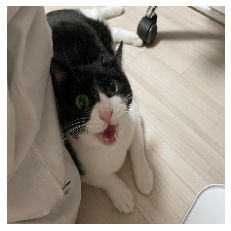

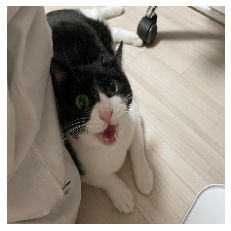

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import array_to_img

#2 
model = VGG16(weights='imagenet', include_top=True)
model.summary()

#3 predict an image
img_path = './San.png'
img = load_img(img_path, target_size = (224, 224))
x = img_to_array(img) # 배열 변환
x = np.expand_dims(x, axis=0) # 배치 축을 추가
x = preprocess_input(x) # RGB순을 BGR순으로 전처리
output = model.predict(x) 

#3-1
print('Predicted:', decode_predictions(output, top=5)[0]) # 가장 확률이 높은 5개 출력

#4
plt.imshow(img)
plt.axis("off")
plt.show(0)

In [18]:
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(28,28,1)),
       tf.keras.layers.Conv2D(256, 3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(10)]
  )

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import array_to_img
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import matplotlib.pyplot as plt

In [25]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer = 'adam',
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])
    
  (x_train, y_train), (x_test, y_test) = cifar10.load_data() # 데이터로드
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  # one-hot
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = preprocess_input(x_test)

  #4 include_top= False로 줘야 학습데이터가 들어옴
  model = VGG16(weights=None, include_top = True, classes = 10, input_shape=(32,32,3))
  model. summary(0)

  #5 
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                  validation_split=0.2, verbose=1)
  train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1)
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

ValueError: ignored